<a href="https://colab.research.google.com/github/Vlasovasona/Python-and-ML-Raschka/blob/main/%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация рукописных цифр


---



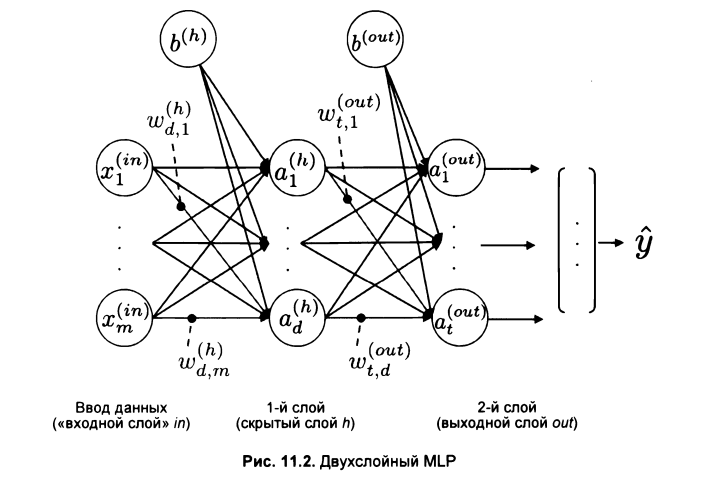

In [1]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1,
                    return_X_y=True)
X = X.values
y = y.astype(int).values

In [2]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [3]:
X = ((X / 255.) - .5) * 2

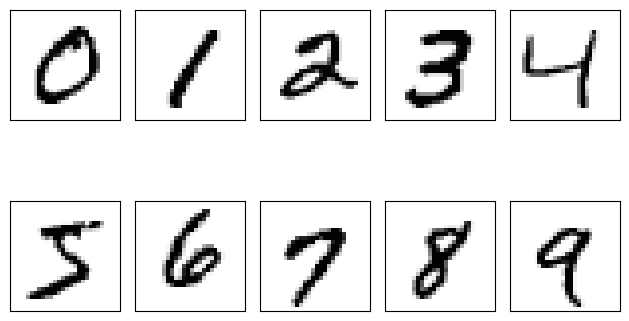

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
  img = X[y == i][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

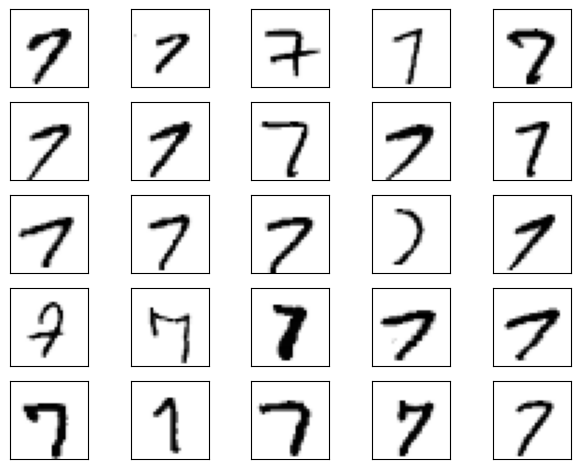

In [5]:
fig, ax = plt.subplots(nrows=5,
                       ncols=5,
                       sharex=True,
                       sharey=True)
ax = ax.flatten()
for i in range(25):
  img = X[y == 7][i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000,
    random_state=123, stratify=y_temp
)

### Реализация многослойного персептрона

In [7]:
import numpy as np

def sigmoid(z):
  """
  Вычисление логистической сигмоидной активации
  param z: линейный классификатор
  """
  return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
  """
  Преобразование массива меток целочисленного класса в метки с
  унитарным кодированием.
  """
  ary = np.zeros((y.shape[0], num_labels))
  for i, val in enumerate(y):
    ary[i, val] = 1
  return ary

In [8]:
class NeuralNetMLP:

  def __init__(self, num_features, num_hidden,
               num_classes, random_seed=123):
    """
    Инициализация нейронной сети с одним скрытым слоем
    params:
    num_features: количество признаков (размерность входных данных)
    num_hidden: количество нейронов в скрытой сети
    num_classes: количество классов для классификации
    """
    super().__init__() # вызов конструктора родительского класса (обычно nn.Module)

    self.num_classes = num_classes

    # скрытый слой
    rng = np.random.RandomState(random_seed)

    # инициализация весов и смещения для скрытого слоя:
    # веса сатрицы между входным слоем и скрытым слоем генерируются из нормального
    # распределения (normal) с центром в нуле и стандартным отклонением 0.1.
    self.weight_h = rng.normal(
        loc=0.0, scale=0.1, size=(num_hidden, num_features)
    )
    self.bias_h = np.zeros(num_hidden) # смещение инициализируется нулями
    #  для каждого нейрона скрытого слоя

    # выход (аналогично коды выше)
    self.weight_out = rng.normal(
        loc=0.0, scale=0.1, size=(num_classes, num_hidden)
    )
    self.bias_out = np.zeros(num_classes)


  def forward(self, x):
    # скрытый слой
    # размерность входа: [n_examples, n_features]
    #                         dot [n_hidden, n_features].T
    # размерность выхода: [n_examples, n_hidden]

    z_h = np.dot(x, self.weight_h.T) + self.bias_h
    a_h = sigmoid(z_h) # функция активации - сигмоида

    # выходной слой
    # размерность входа: [n_examples, n_hidden]
    #                         dot [n_classes, n_hidden].T
    # размерность выхода: [n_examples, n_classes]
    z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
    a_out = sigmoid(z_out)
    return a_h, a_out

  def backward(self, x, a_h, a_out, y):
    """
    a_h — активация скрытого слоя размером [batch_size, hidden_units].
    a_out — выход сети (активации последнего слоя) размером [batch_size, num_classes].
    w_h — матрица весов между входом и скрытым слоем размерами [input_dim, hidden_units].
    b_h — смещения скрытого слоя размеров [hidden_units].
    w_out — матрица весов между скрытым и выходным слоями размерами [hidden_units, num_classes].
    b_out — смещение выходного слоя размеров [num_classes]
    ---------------
    d_loss__dw_out: градиент по весам выходного слоя
    d_loss__db_out: градиент по смещениям выходного слоя
    d_loss__d_w_h: градиент по весам скрытого слоя
    d_loss_d_b_h: градиент по смещениям скрытого слоя
    """
    # веса выходного слоя

    # унитарное кодирование
    y_onehot = int_to_onehot(y, self.num_classes)

    # Часть 1: dLoss/dOutWeights
    # = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
    # where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
    # для удобства повторного использования

    # размер входа/выхода: [n_examples, n_classes]
    d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0] # производная для MSE по a_out

    # размер входа/выхода: [n_examples, n_classes]
    d_a_out__d_z_out = a_out * (1. - a_out) # сигмоидная производная

    # размер выхода: [n_examples, n_classes]
    delta_out = d_loss__d_a_out * d_a_out__d_z_out # перемножаем производные по правилу

    # градиент для выходных весов

    # [n_examples, n_hidden]
    d_z_out__dw_out = a_h

    # размер входа: [n_classes, n_examples] dot [n_examples, n_hidden]
    # размер выхода: [n_classes, n_hidden]
    d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out) # backpropagation
    d_loss__db_out = np.sum(delta_out, axis=0) # получаем вклад смещений в ошибку

    ##########################
    # Часть 2: dLoss/dHiddenWeights
    # = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

    # [n_classes, n_hidden]
    d_z_out__a_h = self.weight_out

    # размер выхода: [n_examples, n_hidden]
    d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

    # [n_examples, n_hidden]
    d_a_h__d_z_h = a_h * (1. - a_h) # сигмоидная производная

    # [n_examples, n_features]
    d_z_h__d_w_h = x

    # размер вызода: [n_hidden, n_features]
    d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
    d_loss_d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

    return (d_loss__dw_out, d_loss__db_out,
            d_loss__d_w_h, d_loss_d_b_h)

In [9]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

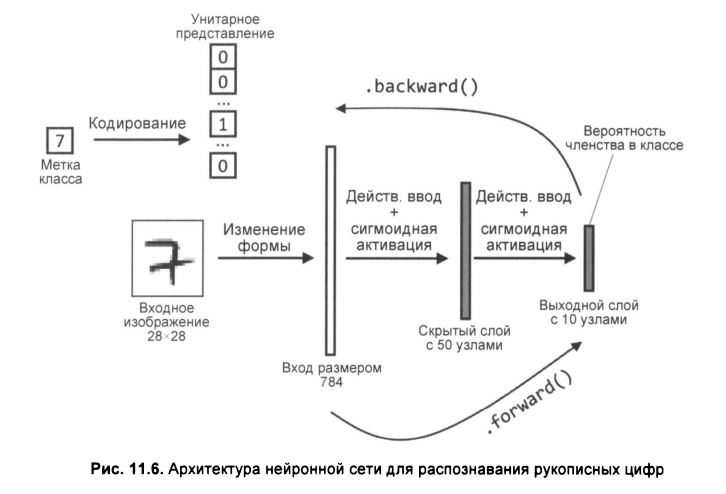

In [11]:
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
  indices = np.arange(X.shape[0]) # сгенерировали массив индексов объектов обучающего датасета
  np.random.shuffle(indices) # перемешали (для рандомизации батчей)
  for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
    # берем срез от start_idx размера батча
    batch_idx = indices[start_idx:start_idx + minibatch_size]
    # генератор, сохраняющий свое состояние между вызовами и начинающий
    # выполнение с последней точки остановки
    yield X[batch_idx], y[batch_idx]

In [12]:
# ПРОВЕРКА КОРРЕТНОСТИ РАБОТЫ ГЕНЕРАТОРА
# итерация по эпохам обучения
for i in range(num_epochs):
  # итерация по батчам
  minibatch_gen = minibatch_generator(
      X_train, y_train, minibatch_size
  )
  for X_train_mini, y_train_mini in minibatch_gen:
    break
  break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [13]:
# определение функции потерь и метрики производительности

def mse_loss(targets, probas, num_labels=10):
  # так как probas принадлежат [0, 1], нужно привести обе величины (probas и targets) к одному виду
  onehot_targets = int_to_onehot(
      targets, num_labels=num_labels
  )
  return np.mean((onehot_targets - probas)**2) # формула MSE

def accuracy(targets, predicted_labels):
  return np.mean(predicted_labels == targets)

In [14]:
# проверка работы функций

_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f'Начальная MSE при валидации: {mse:.1f}')

# выходной слой выдает 10 значений - вероятностей принадлежности объекта
# определенному классу, поэтому argmax
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f'Начальная точность при валидации: {acc*100:.1f}%')

Начальная MSE при валидации: 0.3
Начальная точность при валидации: 9.4%


Используя приведенный код, мы могли бы вычислить производительность для всего обучающего набора, если бы предоставили y_train в качестве входных данных, а метки - с помощью X_train. Однако на практике объем памяти компьютера обычно ограничивает размер данных, которые модель может принять за один прямой проход. Поэтому мы вчисляем MSE и точность с использованием генератора мини-батчей. Следующая функция будет постепенно вычислять MSE и точность, перебирая набор данных по одному батчу за раз, чтобы повысить эффективность использования памяти.

In [15]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
  mse, correct_pred, num_examples = 0., 0, 0
  minibatch_gen = minibatch_generator(X, y, minibatch_size)
  for i, (features, targets) in enumerate(minibatch_gen):
    _, probas = nnet.forward(features)
    predicted_labels = np.argmax(probas, axis=1)
    onehot_targets = int_to_onehot(
        targets, num_labels=num_labels
    )
    loss = np.mean((onehot_targets - probas)**2)
    correct_pred += (predicted_labels == targets).sum()
    num_examples += targets.shape[0]
    mse += loss
  mse = mse/i
  acc = correct_pred/num_examples
  return mse, acc

In [16]:
# проверка compute_mse__and_acc
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Начальная MSE при валидации: {mse:.1f}')
print(f'Начальная точность при валидации: {acc*100:.1f}%')

Начальная MSE при валидации: 0.3
Начальная точность при валидации: 9.4%


In [18]:
# код для обучения модели:

def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
  epoch_loss = []
  epoch_train_acc = []
  epoch_valid_acc = []

  for e in range(num_epochs):
    # итерация по мини-батчам
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size
    )
    for X_train_mini, y_train_mini in minibatch_gen:
      #### Вычисление выходов ####
      a_h, a_out = model.forward(X_train_mini)

      #### Вычисление градиентов ####
      d_loss__d_w_out, d_loss__d_b_out, \
      d_loss__d_w_h, d_loss__d_b_h = \
      model.backward(X_train_mini, a_h, a_out, y_train_mini)

      #### Обновление весов ####
      model.weight_h -= learning_rate * d_loss__d_w_h
      model.bias_h -= learning_rate * d_loss__d_b_h
      model.weight_out -= learning_rate * d_loss__d_w_out
      model.bias_out -= learning_rate * d_loss__d_b_out


    #### Ведение журнала эпох ####
    train_mse, train_acc = compute_mse_and_acc(
        model, X_train, y_train
    )
    valid_mse, valid_acc = compute_mse_and_acc(
        model, X_valid, y_valid
    )
    train_acc, valid_acc = train_acc*100, valid_acc*100
    epoch_train_acc.append(train_acc)
    epoch_valid_acc.append(valid_acc)
    epoch_loss.append(train_mse)
    print(f'Эпоха: {e+1:03d}/{num_epochs:03d} '
    f'| Train MSE: {train_mse:.2f} '
    f'| Train Acc: {train_acc:.2f}% '
    f'| Valid Acc: {valid_acc:.2f}%')

  return epoch_loss, epoch_train_acc, epoch_valid_acc

In [19]:
# np.random.seed(123) перемешивание обучающего набора
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=200, learning_rate=0.1
)

Эпоха: 001/200 | Train MSE: 0.05 | Train Acc: 76.58% | Valid Acc: 76.52%
Эпоха: 002/200 | Train MSE: 0.03 | Train Acc: 85.31% | Valid Acc: 85.00%
Эпоха: 003/200 | Train MSE: 0.02 | Train Acc: 88.06% | Valid Acc: 87.92%
Эпоха: 004/200 | Train MSE: 0.02 | Train Acc: 89.38% | Valid Acc: 89.16%
Эпоха: 005/200 | Train MSE: 0.02 | Train Acc: 90.17% | Valid Acc: 89.80%
Эпоха: 006/200 | Train MSE: 0.02 | Train Acc: 90.61% | Valid Acc: 90.34%
Эпоха: 007/200 | Train MSE: 0.02 | Train Acc: 91.09% | Valid Acc: 90.82%
Эпоха: 008/200 | Train MSE: 0.02 | Train Acc: 91.41% | Valid Acc: 91.14%
Эпоха: 009/200 | Train MSE: 0.01 | Train Acc: 91.73% | Valid Acc: 91.50%
Эпоха: 010/200 | Train MSE: 0.01 | Train Acc: 91.90% | Valid Acc: 91.68%
Эпоха: 011/200 | Train MSE: 0.01 | Train Acc: 92.35% | Valid Acc: 92.00%
Эпоха: 012/200 | Train MSE: 0.01 | Train Acc: 92.48% | Valid Acc: 92.08%
Эпоха: 013/200 | Train MSE: 0.01 | Train Acc: 92.68% | Valid Acc: 92.32%
Эпоха: 014/200 | Train MSE: 0.01 | Train Acc: 92.84

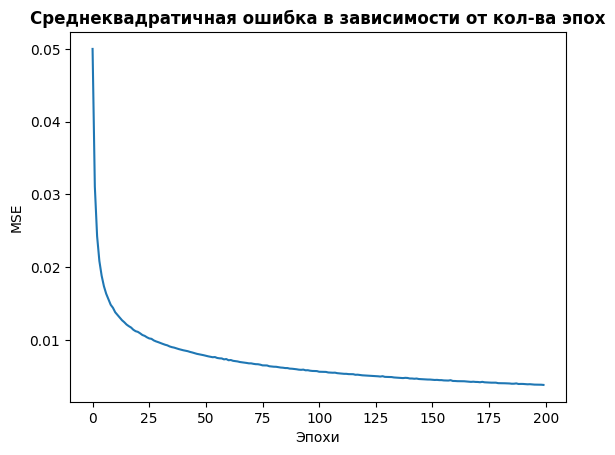

In [21]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('MSE')
plt.xlabel('Эпохи')
plt.title(label='Среднеквадратичная ошибка в зависимости от кол-ва эпох', fontweight='bold')
plt.show()

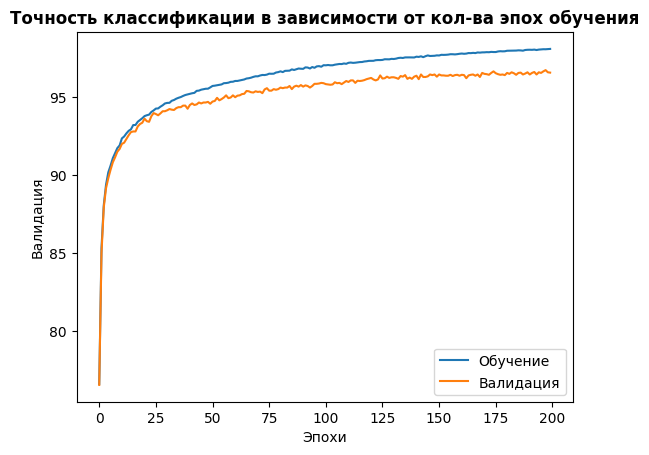

In [22]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Обучение')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Валидация')
plt.ylabel('Валидация')
plt.xlabel('Эпохи')
plt.legend(loc='lower right')
plt.title(label='Точность классификации в зависимости от кол-ва эпох обучения', fontweight='bold')
plt.show()

Примерно на 25 эпохе точность на валидации и на обучении почти равны, потом начинается отдаление -> **переобучение**.

In [23]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Точность при тестировании: {test_acc*100:.2f}%')

Точность при тестировании: 96.14%


Видим, что точность на тесте очень близка к точности на валидации на последней эпохе. Это подтверждает наличие переобучения, но совсем небольшого.

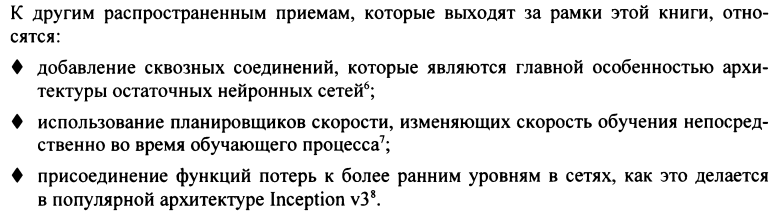